In [2]:
#Libraries - all required except plt (just for checking and visualization) and mp (for viewing final model)
import matplotlib.pyplot as plt
import numpy as np
import triangle as tr
import meshio
import meshplot as mp
import json
import subprocess
import colorsys
import xml.etree.ElementTree as ET

In [3]:
tree = ET.parse('xmls/snake/lady_bug.xml')
root = tree.getroot()

In [7]:
for child in root[:1]:
    for chchild in child:
        print(chchild)

<Element 'control_points_set' at 0x000001BBAC928950>
<Element 'left_colors_set' at 0x000001BBACC15120>
<Element 'right_colors_set' at 0x000001BBACC15300>
<Element 'blur_points_set' at 0x000001BBACC15530>


In [2]:
def form_tri_mesh(file_name:str):
    pts0 = [[0, 0], [0, 0], [0, 0], [0, 0]]
    pts = [pts0]
    seg1 = [[0, 1], [1, 2], [2, 3], [3, 0]]
    seg0 = [seg1]
    pts_index = 1
    seg_index = 1
    seg_num = 4
    lCols0 = [[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0]]
    lCols = [lCols0]
    lCols_index = 1
    rCols0 = [[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0]]
    rCols = [rCols0]
    rCols_index = 1
    xml_image = open(file_name, 'r')
    for line in xml_image:
        line = line.strip()
        if line == '<control_points_set>':
            pts.append([])
            seg0.append([])
            point_line = xml_image.readline().strip()
            while point_line != '</control_points_set>':
                point = []
                num_str = ''
                char = 18
                while char < len(point_line):
                    while point_line[char].isdigit() or point_line[char] == '.':
                        num_str += point_line[char]
                        char += 1
                    if len(num_str) > 0:
                        num = float(num_str)
                        point.insert(0, num)
                        num_str = ''
                    char += 1
                pts[pts_index].append(point)
                seg0[seg_index].append((seg_num, seg_num + 1))
                seg_num += 1
                point_line = xml_image.readline().strip()
            seg0[seg_index] = seg0[seg_index][:len(seg0[seg_index]) - 1]
            pts_index += 1
            seg_index += 1
        elif line == '<left_colors_set>':
            lCols.append([])
            col_line = xml_image.readline().strip()
            while col_line != '</left_colors_set>':
                col = []
                num_str = ''
                char = 0
                while char < len(col_line):
                    while col_line[char].isdigit() or col_line[char] == '.':
                        num_str += col_line[char]
                        char += 1
                    if len(num_str) > 0:
                        num = float(num_str)
                        col.insert(0, num/255)
                        num_str = ''
                    char += 1
                lCols[lCols_index].append(col)
                col_line = xml_image.readline().strip()
            lCols_index += 1
        elif line == '<right_colors_set>':
            rCols.append([])
            col_line = xml_image.readline().strip()
            while col_line != '</right_colors_set>':
                col = []
                num_str = ''
                char = 0
                while char < len(col_line):
                    while col_line[char].isdigit() or col_line[char] == '.':
                        num_str += col_line[char]
                        char += 1
                    if len(num_str) > 0:
                        num = float(num_str)
                        col.insert(0, num/255)
                        num_str = ''
                    char += 1
                rCols[rCols_index].append(col)
                col_line = xml_image.readline().strip()
            rCols_index += 1

    xml_image.close()
    
    for c_s in range(len(lCols)):
        for c in range(len(lCols[c_s])):
            lCols[c_s][c] = [lCols[c_s][c][0], lCols[c_s][c][1], lCols[c_s][c][3]]
    
    for c_s in range(len(rCols)):
        for c in range(len(rCols[c_s])):
            rCols[c_s][c] = [rCols[c_s][c][0], rCols[c_s][c][1], rCols[c_s][c][3]]
    
    for seg in pts:
        for point in seg:
            point[1] *= -1
    seg0T = np.vstack(seg0).tolist()
    ptsT = np.vstack(pts).tolist()
    
    x = []
    y = []
    for dot in ptsT:
        x.append(dot[0])
        y.append(dot[1])

    fig = plt.figure()
    plt.plot(x, y, '.', c=(0,0,0))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    pts[0][0][0] = ax.get_xlim()[0]
    pts[0][3][0] = ax.get_xlim()[0]
    pts[0][1][0] = ax.get_xlim()[1]
    pts[0][2][0] = ax.get_xlim()[1]
    pts[0][0][1] = ax.get_ylim()[0]
    pts[0][1][1] = ax.get_ylim()[0]
    pts[0][2][1] = ax.get_ylim()[1]
    pts[0][3][1] = ax.get_ylim()[1]
    ptsT[0][0] = ax.get_xlim()[0]
    ptsT[3][0] = ax.get_xlim()[0]
    ptsT[1][0] = ax.get_xlim()[1]
    ptsT[2][0] = ax.get_xlim()[1]
    ptsT[0][1] = ax.get_ylim()[0]
    ptsT[1][1] = ax.get_ylim()[0]
    ptsT[2][1] = ax.get_ylim()[1]
    ptsT[3][1] = ax.get_ylim()[1]

    A = dict(vertices=ptsT, segments=seg0T)
    meshObj = tr.triangulate(A)
    plt.close(fig)
    
    return (pts, seg0, meshObj, lCols, rCols)


#Helper function for solve() - determines if a float is between two other floats
def is_between(num, n1, n2):
    if (num <= n1 and num >= n2) or (num >= n1 and num <= n2):
        return True
    else:
        return False

    
#function that determines if a point is between two other points on the same segment
def solve(coordinates) -> bool:
    (x0, y0), (x2, y2) = coordinates[0], coordinates[2]
    x1, y1 = coordinates[1]
    if (abs((x0 - x2) * (y2 - y1) - (x2 - x1) * (y0 - y2)) < 0.001) and (is_between(x1, x0, x2) and is_between(y1, y0, y2)):
        return True
    else:
        return False


#function that determines if a point is kinda between two other points on the same line
def solve_loose(coordinates) -> bool:
    (pointx, pointy), (tocheckx, tochecky) = coordinates[0], coordinates[1]
    if abs(pointx - tocheckx) < 0.15 and abs(pointy - tochecky) < 0.15:
        return True
    else:
        return False


#returns whether or not Pc is to the left of the line formed by P0 and P1 ('left' is relative to orientation of line)
def is_left(P0, P1, Pc):
    res = (P1[0] - P0[0]) * (Pc[1] - P0[1]) - (Pc[0] - P0[0]) * (P1[1] - P0[1])
    if res > 0:
        return True
    else:
        return False


#Basically just is_left but takes in seg as an easier parameter to deal with bc of how triangle sorts its dicts
def what_side(seg, point):
    seg_pt_1 = v[seg0[seg][0]]
    seg_pt_2 = v[seg0[seg][1]]
    res = is_left(seg_pt_1, seg_pt_2, point)
    return res


#Forms lists necessary for further work - inefficient, probably needs some fixing
#This function is specifically for if you're doing dual-side coloured curves
def build_point_lists(v, pts, seg0, segment_lines, all_dots, all_dots_indexed, red_dots, green_dots, green_dots_seg_indexed, green_dots_loose, gdr, gdl, seg_green_left, seg_green_right):
    for line in seg0:
        segment_lines.append([v[line[0]], v[line[1]]])

    red_dots = pts
    for d_i in range(len(red_dots)):
        all_dots_indexed[d_i] = red_dots[d_i]

    for p_i in range(len(v)):
        if v[p_i].tolist() not in red_dots:
            for l_i in range(len(seg0)):
                if solve([v[seg0[l_i][0]], v[p_i], v[seg0[l_i][1]]]):
                    green_dots.append(v[p_i].tolist())
                    all_dots_indexed[p_i] = v[p_i]
                    if l_i in green_dots_seg_indexed:
                        green_dots_seg_indexed[l_i].append((v[p_i][0], v[p_i][1]))
                    else:
                        green_dots_seg_indexed[l_i] = [(v[p_i][0], v[p_i][1])]            

    for p_i in range(len(v)):
        if v[p_i].tolist() not in red_dots and v[p_i].tolist() not in green_dots:
            for seg in green_dots_seg_indexed:
                for point_d in green_dots_seg_indexed[seg]:
                    point = (point_d[0], point_d[1])
                    if point[0] != 10.0 and point[0] != 0.0 and point[1] != 10.0 and point[1] != 0.0 and (solve_loose([point, v[p_i]])):
                        if seg in green_dots_loose:
                            green_dots_loose[seg].append([v[p_i][0], v[p_i][1], p_i])
                        else:
                            green_dots_loose[seg] = [[v[p_i][0], v[p_i][1], p_i]]
    all_dots += red_dots
    all_dots += green_dots

    for seg in green_dots_loose:
        for point in green_dots_loose[seg]:
            if not what_side(seg, [point[0], point[1]]) and point not in gdr:
                gdr.append(point)
                if seg in gdl:
                    gdl[seg].append([point[0], point[1]])
                else:
                    gdl[seg] = [[point[0], point[1]]]
            
    for point in gdr:
        all_dots.append([point[0], point[1]])
        all_dots_indexed[point[2]] = [point[0], point[1]]
    
    for p_i in range(len(all_dots) - len(gdr), len(all_dots)):
        point = all_dots[p_i]
        for seg in gdl:
            if point in gdl[seg]:
                if seg in seg_green_right:
                    seg_green_right[seg].append([point[0], point[1], p_i])
                else:
                    seg_green_right[seg] = [[point[0], point[1], p_i]]
    
    for line_index in range(len(segment_lines)):
        for p_i in range(len(green_dots)):
            if solve([segment_lines[line_index][0], green_dots[p_i], segment_lines[line_index][1]]):
                if line_index in seg_green_left:
                    seg_green_left[line_index].append((green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots)))
                else:
                    seg_green_left[line_index] = [(green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots))]


#Forms lists necessary for further work - inefficient, probably needs some fixing
#This function is specifically for if you're NOT doing dual-side colours
def build_point_lists(v, pts, seg0, segment_lines, all_dots, all_dots_indexed, red_dots, green_dots, seg_green_right):
    for line in seg0:
        segment_lines.append([v[line[0]], v[line[1]]])

    red_dots = pts
    for d_i in range(len(red_dots)):
        all_dots_indexed[d_i] = red_dots[d_i]

    for p_i in range(len(v)):
        if v[p_i].tolist() not in red_dots:
            for l_i in range(len(seg0)):
                if solve([v[seg0[l_i][0]], v[p_i], v[seg0[l_i][1]]]):
                    green_dots.append(v[p_i].tolist())
                    all_dots_indexed[p_i] = v[p_i]
                    
    all_dots += red_dots
    all_dots += green_dots
    
    for line_index in range(len(segment_lines)):
        for p_i in range(len(green_dots)):
            if solve([segment_lines[line_index][0], green_dots[p_i], segment_lines[line_index][1]]):
                if line_index in seg_green_left:
                    seg_green_left[line_index].append((green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots)))
                else:
                    seg_green_left[line_index] = [(green_dots[p_i][0], green_dots[p_i][1], p_i + len(red_dots))]


#Generate RANDOM rgb values for manually plotted points (red_dots)
def random_seg_colours(rgb_segs, seg_start):
    random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour1 == (0, 0, 0) or random_colour1 == (1, 1, 1):
        random_colour1 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    while random_colour2 == (0, 0, 0) or random_colour2 == (1, 1, 1):
        random_colour2 = np.random.randint(2), np.random.randint(2), np.random.randint(2)
    segm = [(segment_lines[seg_start][0][0], segment_lines[seg_start][0][1]), (segment_lines[seg_start][1][0], segment_lines[seg_start][1][1])]
    rgb_segs.append({"segment": segm, "colours": [random_colour1, random_colour2]})

    for segment_index in range(seg_start+1, len(segment_lines)):
        random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        while random_colour == (0, 0, 0) or random_colour == (1, 1, 1):
            random_colour = np.random.randint(2), np.random.randint(2), np.random.randint(2)
        segm = [(segment_lines[segment_index][0][0], segment_lines[segment_index][0][1]), (segment_lines[segment_index][1][0], segment_lines[segment_index][1][1])]
        rgb_segs.append({"segment": segm, "colours": [rgb_segs[segment_index - (seg_start + 1)]["colours"][1], random_colour]})
    
    if len(loop_backs) > 0:
        i = 0
        while i < len(loop_backs) and loop_backs[i] < seg_start:
            i += 1
        if i < len(loop_backs):
            rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
            for loop_num_i in range(1, len(loop_backs)):
                rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]


#Generate MANUALLY PLOTTED rgb values for manually plotted points (red_dots)
def fixed_seg_colours(rgb_segs, cols, seg_start):    
    segm = [(segment_lines[seg_start][0][0], segment_lines[seg_start][0][1]), (segment_lines[seg_start][1][0], segment_lines[seg_start][1][1])]
    rgb_segs.append({"segment": segm, "colours": [cols[0], cols[1]]})

    for i in range(seg_start + 1, len(segment_lines)):
        segm = [(segment_lines[i][0][0], segment_lines[i][0][1]), (segment_lines[i][1][0], segment_lines[i][1][1])]
        rgb_segs.append({"segment": segm, "colours": [cols[i - (seg_start+1)], cols[i - seg_start]]})
        
    rgb_segs[loop_backs[0]]['colours'][1] = rgb_segs[0]['colours'][0]
    for loop_num_i in range(1, len(loop_backs)):
        rgb_segs[loop_backs[loop_num_i]]['colours'][1] = rgb_segs[loop_backs[loop_num_i - 1]+1]['colours'][0]


#Function converts mesh into HSV interpolation - do not run if you want to do RGB interpolation
def hsv_interpolation():
    global isHsv
    isHsv = True
    for seg in rgb_segs:
        col1 = seg['colours'][0]
        col2 = seg['colours'][1]
        seg['colours'] = []
        seg['colours'].append(colorsys.rgb_to_hsv(col1[0], col1[1], col1[2]))
        seg['colours'].append(colorsys.rgb_to_hsv(col2[0], col2[1], col2[2]))


#Takes colours from rgb_segs and maps individual points - inefficient, could find way to do this without rgb_points AND rgb_segs
def point_seg_align(rgb_points, rgb_segs, seg_start):
    i = 0
    while i < len(iso_segs) and iso_segs[i] < seg_start:
        i += 1
    if i < len(iso_segs):
        iso_count = 0
        for point_index in range(len(rgb_segs)):
            col = rgb_segs[point_index]['colours'][0]
            rgb_points[point_index + iso_count] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}
            if point_index in iso_segs[i:]:
                col = rgb_segs[point_index]['colours'][1]
                iso_count += 1
                rgb_points[point_index + iso_count] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}
    else:
        for point_index in range(seg_start, len(red_dots)):
            col = rgb_segs[point_index]['colours'][0]
            rgb_points[point_index] = {"point": (red_dots[point_index + seg_start][0], red_dots[point_index + seg_start][1]), "colour": col}


#Take colour values of red_dots and figure out what the dots on those segments should be coloured
def interpolate_points(rgb_points, rgb_segs, segment_green_points, point_start, seg_start):
    for seg in segment_green_points:
        for point in segment_green_points[seg]:
            line = segment_lines[seg]
            line_height = abs(line[0][1] - line[1][1])
            line_width = abs(line[0][0] - line[1][0])
            rel_height = abs(point[1] - line[0][1])
            rel_width = abs(point[0] - line[0][0])
            ratio = max(rel_height, rel_width) / max(line_height, line_width)

            start_r, start_g, start_b = rgb_segs[seg - seg_start]["colours"][0]
            end_r, end_g, end_b = rgb_segs[seg - seg_start]["colours"][1]

            r = ((end_r - start_r) * ratio) + start_r
            g = ((end_g - start_g) * ratio) + start_g
            b = ((end_b - start_b) * ratio) + start_b
            
            if r < 0:
                r = 0
            elif r > 1:
                r = 1
            if g < 0:
                g = 0
            elif g > 1:
                g = 1
            if b < 0:
                b = 0
            elif b > 1:
                b = 1

            pnt_obj = {"point": (point[0], point[1]), "colour": (r, g, b)}
            rgb_points[point[2] - point_start] = pnt_obj

In [4]:
def build_segments(file_name:str, useRight:bool=False, fixedCols:bool=False, useHsv:bool=False):
    tri_out = form_tri_mesh(file_name)
    pts = tri_out[0]
    seg0 = tri_out[1]
    meshObj = tri_out[2]
    lCols = tri_out[3]
    rCols = tri_out[4]
    
    v = meshObj['vertices']
    segment_lines = []
    all_dots = []
    all_dots_indexed = {}
    red_dots = []
    green_dots = []
    seg_green_left = {}
    
    #only if useRight
    green_dots_seg_indexed = {}
    green_dots_loose = {}
    gdr = []
    gdl = {}
    seg_green_right = {}
    
    
    if useRight:
        build_point_lists(v, pts, seg0, segment_lines, all_dots, all_dots_indexed, red_dots, green_dots, green_dots_seg_indexed, green_dots_loose, gdr, gdl, seg_green_left, seg_green_right)
    else:
        build_point_lists(v, pts, seg0, segment_lines, all_dots, all_dots_indexed, red_dots, green_dots, seg_green_left)

    rgb_segs_left = []
    rgb_segs_right = []

    if fixedCols:
        fixed_colours(rgb_segs_left, left_list, 0)
        if useRight:
            fixed_colours(rgb_segs_right, right_list, 4)
    else:
        random_colours(rgb_segs_left, 0)
        if useRight:
            random_colours(rgb_segs_right, 4)
    
    if useHsv:
        hsv_interpolation()

    rgb_points_left = []
    rgb_points_right = []
    
    if useRight:
        for i in range(len(all_dots) - len(gdr)):
            rgb_points_left.append(None)
        for i in range(len(gdr)):
            rgb_points_right.append(None)
    else:
        for i in range(len(all_dots)):
            rgb_points_left.append(None)


    point_seg_align(rgb_points_left, rgb_segs_left, 0)
    if useRight:
        point_seg_align(rgb_points_right, rgb_segs_right, 4)
    
    interpolate_points(rgb_points_left, rgb_segs_left, seg_green_left, 0, 0)
    if useRight:
        interpolate_points(rgb_points_right, rgb_segs_right, seg_green_right, len(all_dots) - len(gdr), 4)
    
    return (rgb_points_left, rgb_points_right, isHsv, all_dots_indexed, meshObj)

In [3]:
tri_out = form_tri_mesh('xmls/snake/lady_bug.xml')
pts = tri_out[0]
seg0 = tri_out[1]
meshObj = tri_out[2]
lCols = tri_out[3]
rCols = tri_out[4]

In [8]:
for p in pts:
    print((len(p) - 4) % 3)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


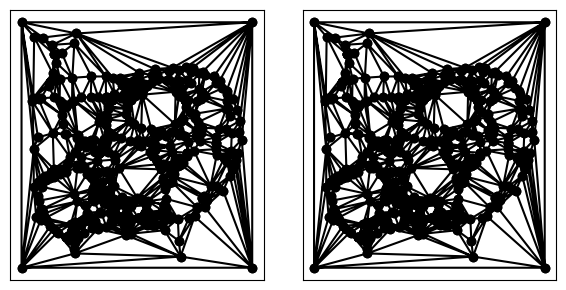

In [5]:
tr.compare(plt, meshObj, meshObj)

In [71]:
def make_cols_match(cols, pts):
    new_cols = []
    for s in range(len(pts)):
        if len(pts[s]) > len(cols[s]):
            rs = []
            for c in range(len(cols[s])):
                rs.append((len(pts[s]) - 1) * (c/(len(cols[s]) - 1)))
            new_cols.append([])
            for i in range(len(pts[s])):
                new_cols[s].append(None)
            for c in range(len(cols[s])):
                new_cols[s][int(rs[c])] = cols[s][c]
            where_none = []
            for c in range(len(new_cols[s])):
                if new_cols[s][c] == None:
                    where_none.append(c)
            return([where_none, rs, new_cols])

In [77]:
cols = [[]]
for i in range(10):
    cols[0].append([0, 0, 0])
pts = [[]]
for i in range(60):
    pts[0].append([0, 0])
b = make_cols_match(cols, pts)
b

[[1,
  2,
  3,
  4,
  5,
  7,
  8,
  9,
  10,
  11,
  12,
  14,
  15,
  16,
  17,
  18,
  20,
  21,
  22,
  23,
  24,
  25,
  27,
  28,
  29,
  30,
  31,
  33,
  34,
  35,
  36,
  37,
  38,
  40,
  41,
  42,
  43,
  44,
  46,
  47,
  48,
  49,
  50,
  51,
  53,
  54,
  55,
  56,
  57,
  58],
 [0.0,
  6.555555555555555,
  13.11111111111111,
  19.666666666666664,
  26.22222222222222,
  32.77777777777778,
  39.33333333333333,
  45.88888888888889,
  52.44444444444444,
  59.0],
 [[[0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],
   None,
   None,
   None,
   None,
   None,
   None,
   [0, 0, 0],


In [ ]:
#fuck :)
#Try and find a way of interpolating I guess? I'm tired dsfjsk